In [36]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from itertools import permutations
import random
import itertools

In [37]:
def generate_random_clause(n):
    """
    Generates a random clause for EC3 by selecting three distinct bits (0-based indices).
    n: Number of bits.
    """
    return tuple(random.sample(range(n), 3))

def is_clause_satisfied(clause, assignment):
    """
    Checks if a given clause is satisfied by the assignment.
    A clause is satisfied if exactly one of the three bits is 1.
    """
    return sum(assignment[i] for i in clause) == 1

def find_satisfying_assignments(n, clauses):
    """
    Finds all satisfying assignments for the given clauses.
    n: Number of bits.
    clauses: List of clauses (each clause is a tuple of three distinct bit indices).
    Returns a list of all assignments (as tuples) that satisfy all clauses.
    """
    satisfying_assignments = []
    all_assignments = itertools.product([0, 1], repeat=n)  # Generate all 2^n possible assignments
    
    for assignment in all_assignments:
        if all(is_clause_satisfied(clause, assignment) for clause in clauses):
            satisfying_assignments.append(assignment)
    
    return satisfying_assignments

def generate_ec3_instance(n):
    """
    Generates a valid EC3 instance with n bits, such that there is exactly one satisfying assignment.
    """
    clauses = []
    
    while True:
        # Add a random clause
        new_clause = generate_random_clause(n)
        clauses.append(new_clause)
        
        # Find satisfying assignments
        satisfying_assignments = find_satisfying_assignments(n, clauses)
        
        # If there's exactly one satisfying assignment, accept the instance
        if len(satisfying_assignments) == 1:
            return clauses, satisfying_assignments[0]  # Return the clauses and the satisfying assignment
        
        # If there are no satisfying assignments, reject the instance and start over
        if len(satisfying_assignments) == 0:
            clauses = []  # Reset the clauses and try again

In [52]:
# Number of qubits
n_qubits = 4

clauses, satisfying_assignment = generate_ec3_instance(n_qubits)

# unique_solution = generate_random_solution(n_qubits)
# print(unique_solution)
# clauses = generate_unique_ec3_instance(n_qubits, 3, unique_solution)

print(f"Unique satisfying bitstring: {''.join(map(str, satisfying_assignment))}")

print(f"Generated EC3 clauses (n={n_qubits}):")
for clause in clauses:
    print(clause)
    

# Define single-qubit Pauli-X and Identity matrices
I = qeye(2)
I_n = tensor([I for _ in range(n_qubits)])
X = sigmax()
Z = sigmaz()

def H_B(clauses):
    H_b = Qobj(qzero(2**n_qubits))
    for (i, j, k) in clauses:
        H_b += 0.5 * Qobj(((I_n - tensor([X if x == i else I for x in range(n_qubits)])) + 
                  (I_n - tensor([X if x == j else I for x in range(n_qubits)])) +
                  (I_n - tensor([X if x == k else I for x in range(n_qubits)]))).data, dims=H_b.dims)
    return H_b

def check_clause_violation(state_binary, clause):
    i, j, k = clause
    bits = [state_binary[i], state_binary[j], state_binary[k]]
    return sum(bits) != 1

def cost_function(z, clauses):
    bitstring = f"{z:0{n_qubits}b}"
    bit_values = [int(b) for b in bitstring] 

    violations = 0
    for clause in clauses:
        if check_clause_violation(bit_values, clause):
            violations += 1  # Clause is violated

    return violations

# Problem Hamiltonian H_P
def H_P(clauses):
    H_p = qeye(2**n_qubits)
    for z in range(2**n_qubits):
        state = basis(2**n_qubits, z)

        h_z = cost_function(z, clauses)
        projector_z = state * state.dag()
        
        H_p += h_z * projector_z
    return H_p

def H_t(s, Hp, Hb):
    return (1 - s) * Hb + s * Hp

def H_C_calc(t, args):
    H_c = Qobj(qzero(2**n_qubits))
    s = t / args['t_max']
    for clause in args['clauses']:
        H_B_C = H_B([clause])
        H_B_P = H_P([clause])
        H_c += H_B_C*(1 - s) + H_B_P*s
    return H_c

Unique satisfying bitstring: 0100
Generated EC3 clauses (n=4):
(0, 2, 1)
(2, 0, 1)
(2, 3, 1)
(0, 1, 3)


Energy diff is:  0.4287273643527103
Energy spectrum at beginning:  [0, 2, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 9, 9, 10, 12]
Energy spectrum at end:  [1, 2, 3, 4, 5]


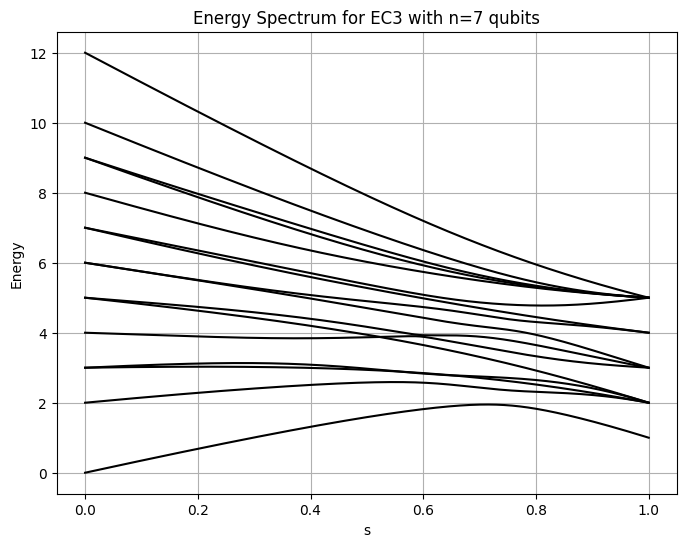

In [53]:
s_values = np.linspace(0, 1, 1000)
Hb = H_B(clauses)
Hp = H_P(clauses)

energy_diff = None
# Calculate the energy spectrum
energy_spectrum = []
for s in s_values:
    H = H_t(s, Hp, Hb)
    energies = H.eigenenergies()
    energy_spectrum.append(energies)
    
    eg_inst = energies[1] - energies[0]
    if not energy_diff:
        energy_diff = eg_inst
    if energy_diff > eg_inst:
        energy_diff = eg_inst

print("Energy diff is: ", energy_diff)

energy_spectrum = np.array(energy_spectrum)
# Plot the energy spectrum
plt.figure(figsize=(8, 6))
for i in range(2**n_qubits):
    plt.plot(s_values, energy_spectrum[:, i], color='black')
    
print("Energy spectrum at beginning: ", [int(np.round(i)) for i in energy_spectrum[0]])
print("Energy spectrum at end: ", [int(np.round(i)) for i in set(energy_spectrum[-1])])

plt.xlabel('s')
plt.ylabel('Energy')
plt.title('Energy Spectrum for EC3 with n=7 qubits')
plt.grid(True)
plt.show()

In [54]:
# Ground state of Hb at the beginning of the protocol
eigenvalues_initial, eigenstates_initial = Hb.eigenstates()
initial_gs = eigenstates_initial[0]
# Ground state of Hp at the ending of the protocol
eigenvalues_final, eigenstates_final = Hp.eigenstates()
final_gs = eigenstates_final[0]

omega_ba = eigenvalues_final[0] - eigenvalues_initial[0]

solution_bitstring_index = np.argmax(np.abs(final_gs.full()))
solution_bitstring = f"{solution_bitstring_index:0{n_qubits}b}"

print(f"Solution bitstring (EC3 solution): {solution_bitstring}")

Solution bitstring (EC3 solution): 0100


0.587


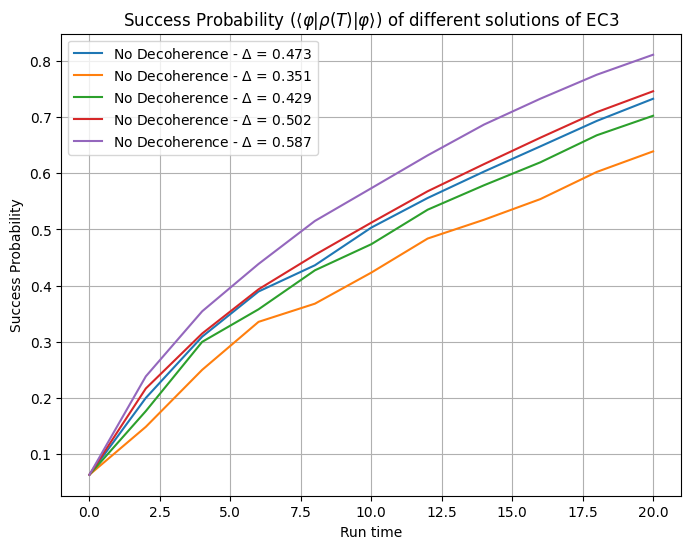

In [7]:
E_gaps = []
s_values = np.linspace(0, 1, 100)

t_fs = np.linspace(0, 20, 11)
tf_iters = 100

w = lambda t, args: 1 - (t / int(np.max(times)))
f = lambda t, args: (t / int(np.max(times)))

rho0 = initial_gs * initial_gs.dag()

plt.figure(figsize=(8, 6))

while len(E_gaps) <= 4:
    clauses, satisfying_assignment = generate_ec3_instance(n_qubits)

    Hb = H_B(clauses)
    Hp = H_P(clauses)
    
    energy_diff = None
    for s in s_values:
        H = H_t(s, Hp, Hb)
        energies = H.eigenenergies()
        
        eg_inst = energies[1] - energies[0]
        if not energy_diff:
            energy_diff = eg_inst
        if energy_diff > eg_inst:
            energy_diff = eg_inst
    
    energy_diff = round(energy_diff,3)
    if energy_diff not in E_gaps:
        E_gaps.append(energy_diff)

        eigenvalues_final, eigenstates_final = Hp.eigenstates()
        final_gs = eigenstates_final[0]

        H_obj = [[Hb, w], [Hp, f]]    
        exps_se = []
        for ind, tf in enumerate(t_fs[1:]):
            times = np.linspace(0, tf, tf_iters)
            results = sesolve(H_obj, initial_gs, times)
        
            states = results.states
            if ind == 0:
                exps_se.append(expect(ket2dm(states[0]), final_gs))    
            exps_se.append(expect(ket2dm(states[-1]), final_gs))
        
        plt.plot(t_fs, exps_se, label=r"No Decoherence - $\Delta$ = " + str(energy_diff), linewidth=1.5)

print(energy_diff)

# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$"
          + ') of different solutions of EC3')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / (temperature)) - 1)

def gab(omega1, omega2, lambda_2):
    if omega1 >= omega2:
        return 0
    return np.sqrt(lambda_2)

def H_s_t(t, args):
    s = t / args['t_max']
    return (1 - s) * args['Hb'] + s * args['Hp']
  
def rho_P(T):
    eigenvalues, eigenstates = Hp.eigenstates()
    Z = np.sum([np.exp(-ev / T) for ev in eigenvalues])
    # Thermal density matrix
    return sum([np.exp(-eigenvalues[i] / T) * eigenstates[i] * eigenstates[i].dag() for i in range(len(eigenstates))]) / Z

In [ ]:
def c_ops_gen(t, args):
    """
    Robustness of adiabatic quantum computation - from this paper
    :param t: time parameter 
    :param args: dictionary of optional arguments
    :return: a matrix of the collapse operator
    """
    H_inst_t = H_s_t(t, args['args_H'])  # Instantaneous Hamiltonian at time t
    eigenvalues, eigenstates = H_inst_t.eigenstates()
    
    sigmam_i = args['sigma_i']
    sigmap_i = sigmam_i.dag()
    
    # Initialize a single collapse operator for this qubit
    collapse_op = Qobj(np.zeros_like(sigmam_i.full()), dims=sigmam_i.dims)
    
    for omega_a, a in zip(eigenvalues, eigenstates):
        for omega_b, b in zip(eigenvalues, eigenstates):
            if np.abs(omega_a - omega_b) < 1e-6:
                continue  # Skip nearly degenerate states
            
            sigmam_ab = a.dag() * sigmam_i * b  # decay transition matrix element
            sigmap_ba = b.dag() * sigmam_i * a # excitation transition matrix element
            
            # For decay transitions (omega_b > omega_a)
            if omega_b > omega_a:
                Nba = bose_einstein_distribution(omega_b - omega_a, args['T'])
                g_ba = gab(omega_a, omega_b, args['lambda_2'])
                
                # ma_ba = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                ma_ba = a.dag() * sigmam_i * b
                
                # decay_op = np.sqrt(Nba * (g_ba ** 2)) * sigmam_ab * a * b.dag()
                decay_op = np.sqrt(Nba * (g_ba ** 2) * ma_ba) * (b * a.dag())
                # decay_op = np.sqrt((Nba * (g_ba ** 2) * ma_ba) / 2) * (b * a.dag())
                # decay_op = Nba * (g_ba ** 2) * ma_ba * (b * a.dag())
                # decay_op = np.sqrt(Nba * (g_ba ** 2)) * ma_ba * (b * a.dag())
                # decay_op = np.sqrt(Nba * (g_ba ** 2) * ma_ba) * sigmam_i * (b * a.dag())
                # decay_op = np.sqrt(Nba * (g_ba ** 2)) * sigmam_i * (b * a.dag())
                # decay_op = np.sqrt(Nba * (g_ba ** 2) * ma_ba) * sigmam_i
                # decay_op = np.sqrt(Nba * (g_ba ** 2)) * sigmam_i
                collapse_op += decay_op

            # For excitation transitions (omega_a > omega_b)
            elif omega_a > omega_b:
                Nab = bose_einstein_distribution(omega_a - omega_b, args['T'])
                g_ab = gab(omega_b, omega_a, args['lambda_2'])
                
                # ma_ab = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                ma_ab = b.dag() * sigmam_i * a
                
                # excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2)) * sigmap_ba * b * a.dag()
                excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab) * (a * b.dag())
                # excitation_op = np.sqrt(((Nab + 1) * (g_ab ** 2) * ma_ab) / 2) * (b * a.dag())
                # excitation_op = (Nab + 1) * (g_ab ** 2) * ma_ab * (b * a.dag())
                # excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2)) * ma_ab * (b * a.dag())
                # excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab) * sigmap_i * (a * b.dag())
                # excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2)) * sigmap_i * (a * b.dag())
                # excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab) * sigmap_i
                # excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2)) * sigmap_i
                collapse_op += excitation_op
                
    return collapse_op

In [ ]:
t_fs = np.linspace(0, 20, 6)
tf_iters = 2

w = lambda t, args: 1 - (t / int(np.max(times)))
f = lambda t, args: (t / int(np.max(times)))
H_obj = [[Hb, w], [Hp, f]]

rho0 = initial_gs * initial_gs.dag()

lambda_2 = 0.1
temperatures = [1/10, 1/2, 1, 2, 10]
# temperatures = [0.1]

expects_at_end = []
plt.figure(figsize=(8, 6))
for T in temperatures:
    print('Working on temp:', T)
    
    exps_me = []
    for ind, tf in enumerate(t_fs[1:]):
        print('Working on RunTime T =', tf)
        times = np.linspace(0, tf, tf_iters)

        args_H = {'t_max': tf,
                  'Hb': Hb,
                  'Hp': Hp
                 }
        
        c_ops_s = []
        for i in range(n_qubits):
            args_C = {"args_H": args_H,
                      "n_qubits": n_qubits,
                      "lambda_2":lambda_2,
                      "T":T,
                      "sigma_i": Qobj(tensor([sigmam() if j == i else I for j in range(n_qubits)]).data, dims=Hp.dims)
                     }
            c_ops_i = QobjEvo(c_ops_gen, args=args_C)
            c_ops_s.append(c_ops_i)
                
        results = mesolve(H_obj, rho0, times, c_ops=c_ops_s, options={'nsteps': 10000, 'atol': 1e-3})
        # options={'nsteps': 100000, 'atol': 1e-2}
        
        if ind == 0:
            exps_me.append(expect(results.states[0], final_gs))    

        exps_me.append(expect(results.states[-1], final_gs))
    plt.plot(t_fs, exps_me, "-o", label=f"T = {T}")  # Success probability

        
    #thermal success probabilities
    expects_at_end.append(expect(rho_P(T), final_gs))
    
x_s = [np.max(t_fs) + 0.5 for _ in range(len(temperatures))]
plt.plot(x_s, expects_at_end, '<', color='black')

exps_se = []
for ind, tf in enumerate(t_fs[1:]):
    times = np.linspace(0, tf, tf_iters)
    results = sesolve(H_obj, initial_gs, times)

    states = results.states
    
    if ind == 0:
        exps_se.append(expect(ket2dm(states[0]), final_gs))
        
    exps_se.append(expect(ket2dm(states[-1]), final_gs))

plt.plot(t_fs, exps_se, '--', label="No Decoherence", color='black', linewidth=1.5)

# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$"
          + ') with Decoherence at Different Temperatures - '
          + r'$\Delta$'
          + ' = {} - '.format(round(energy_diff,3))
          + r'$\lambda^{2}$'
          + ' = {}'.format(lambda_2))
plt.legend()
plt.grid(True)
plt.show()

Working on temp: 0.1
Working on RunTime T = 4.0
Working on RunTime T = 8.0
Working on RunTime T = 12.0
Working on RunTime T = 16.0
Working on RunTime T = 20.0
Working on temp: 0.5
Working on RunTime T = 4.0
Working on RunTime T = 8.0
Working on RunTime T = 12.0
Working on RunTime T = 16.0
Working on RunTime T = 20.0
Working on temp: 1
Working on RunTime T = 4.0
Working on RunTime T = 8.0
Working on RunTime T = 12.0
Working on RunTime T = 16.0
Working on RunTime T = 20.0
Working on temp: 2
Working on RunTime T = 4.0
Working on RunTime T = 8.0
Working on RunTime T = 12.0
Working on RunTime T = 16.0
Working on RunTime T = 20.0


Working on Eg = 0.429
Working on RunTime T = 2.0
Working on RunTime T = 4.0
Working on RunTime T = 6.0
Working on RunTime T = 8.0
Working on RunTime T = 10.0
Working on RunTime T = 12.0
Working on RunTime T = 14.0
Working on RunTime T = 16.0
Working on RunTime T = 18.0
Working on RunTime T = 20.0
Working on Eg = 0.351
Working on RunTime T = 2.0
Working on RunTime T = 4.0
Working on RunTime T = 6.0
Working on RunTime T = 8.0
Working on RunTime T = 10.0
Working on RunTime T = 12.0
Working on RunTime T = 14.0
Working on RunTime T = 16.0
Working on RunTime T = 18.0
Working on RunTime T = 20.0
Working on Eg = 0.473
Working on RunTime T = 2.0
Working on RunTime T = 4.0
Working on RunTime T = 6.0
Working on RunTime T = 8.0
Working on RunTime T = 10.0
Working on RunTime T = 12.0
Working on RunTime T = 14.0
Working on RunTime T = 16.0
Working on RunTime T = 18.0
Working on RunTime T = 20.0
Working on Eg = 0.587
Working on RunTime T = 2.0
Working on RunTime T = 4.0
Working on RunTime T = 6.0
Wor

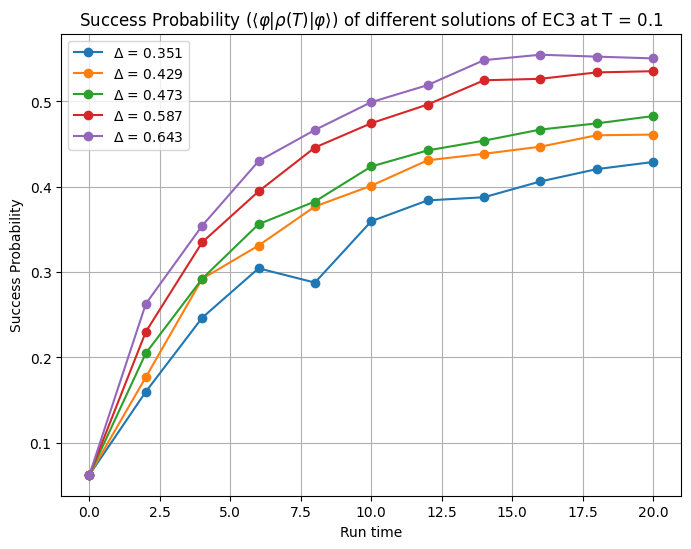

In [11]:
E_gaps = []
results_data = []  # Store energy gaps and corresponding success probabilities
s_values = np.linspace(0, 1, 100)

t_fs = np.linspace(0, 20, 11)
tf_iters = 100

w = lambda t, args: 1 - (t / int(np.max(times)))
f = lambda t, args: (t / int(np.max(times)))

rho0 = initial_gs * initial_gs.dag()

T = 0.1
lambda_2 = 0.1

while len(E_gaps) <= 4:
    clauses, satisfying_assignment = generate_ec3_instance(n_qubits)

    Hb = H_B(clauses)
    Hp = H_P(clauses)
    
    energy_diff = None
    for s in s_values:
        H = H_t(s, Hp, Hb)
        energies = H.eigenenergies()
        
        eg_inst = energies[1] - energies[0]
        if not energy_diff:
            energy_diff = eg_inst
        if energy_diff > eg_inst:
            energy_diff = eg_inst
    
    energy_diff = round(energy_diff, 3)
    if energy_diff not in E_gaps:
        E_gaps.append(energy_diff)

        eigenvalues_final, eigenstates_final = Hp.eigenstates()
        final_gs = eigenstates_final[0]

        H_obj = [[Hb, w], [Hp, f]]   
        
        exps_me = []
        print('Working on Eg =', energy_diff)
        for ind, tf in enumerate(t_fs[1:]):
            print('Working on RunTime T =', tf)
            times = np.linspace(0, tf, tf_iters)
    
            args_H = {'t_max': tf,
                      'Hb': Hb,
                      'Hp': Hp
                     }
            
            c_ops_s = []
            for i in range(n_qubits):
                args_C = {"args_H": args_H,
                          "n_qubits": n_qubits,
                          "lambda_2": lambda_2,
                          "T": T,
                          "sigma_i": Qobj(tensor([sigmam() if j == i else I for j in range(n_qubits)]).data, dims=Hp.dims)
                         }
                c_ops_i = QobjEvo(c_ops_gen, args=args_C)
                c_ops_s.append(c_ops_i)
                    
            results = mesolve(H_obj, rho0, times, c_ops=c_ops_s, options={'nsteps': 100000,
                                                                          'atol': 1e-2})
            
            if ind == 0:
                exps_me.append(expect(results.states[0], final_gs))    
    
            exps_me.append(expect(results.states[-1], final_gs))
        
        # Store energy gap and corresponding success probabilities
        results_data.append((energy_diff, exps_me))

# Sort the results by energy gap
results_data.sort(key=lambda x: x[0])

# Plot the results
plt.figure(figsize=(8, 6))
for energy_diff, exps_me in results_data:
    plt.plot(t_fs, exps_me, "-o", label=r"$\Delta$" + f" = {energy_diff}")

# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$"
          + ') of different solutions of EC3' + f" at T = {T}")
plt.legend()
plt.grid(True)
plt.show()
